# Part 1: ASX 200 vs. Twitter Sentiments.

We will first compare the ASX 200 with Twitter Senitments datasets to attempt to identify a relationship between markets and general sentiment. We start by loading in and storing the ASX 200 data from the ElasticSearch.

In [7]:
import pandas as pd
import requests

# Load data from ElasticSearch.
URL = 'http://127.0.0.1:9090/asx/daily'
res = requests.get(URL)
rjson = res.json()

# Iterate over and preprocess ASX data.
asx_daily = []
for hit in rjson['result']['hits']:
    date = pd.to_datetime(hit["_source"]["Date"], format="%Y-%m-%d").normalize()
    price = float(hit["_source"]["Price"])
    change_string = hit["_source"]["Change %"]
    while change_string[-1] == '%':
        change_string = change_string[:-1]
    change = float(change_string)
    asx_daily.append((date, price, change))

# Store ASX Data in Pandas dataframe.
asx_daily.sort()
df_asx_daily = pd.DataFrame(asx_daily, columns=("Date", "ASX Price", "ASX Change (%)"))
df_asx_daily.head(10)

,Date,ASX Price,ASX Change (%)
0,2021-06-21,7235.3,-1.81
1,2021-06-22,7342.2,1.48
2,2021-06-23,7298.5,-0.60
3,2021-06-24,7275.3,-0.32
4,2021-06-25,7308.0,0.45
5,2021-06-28,7307.3,-0.01
6,2021-06-29,7301.2,-0.08
7,2021-06-30,7313.0,0.16
8,2021-07-01,7265.6,-0.65
9,2021-07-02,7308.6,0.59


Now we scan and load in the data from the Twitter dataset.

In [8]:
# Load data from ElasticSearch.
URL = 'http://127.0.0.1:9090/tweets/daily'
res = requests.get(URL)
rjson = res.json()

# Exclude dates in the daterange that ElasticSearch falsely initialized.
EXCLUDE_DATES = {pd.to_datetime('2021-06-25'), pd.to_datetime('2022-03-29'), pd.to_datetime('2021-09-08'),
                 pd.to_datetime('2021-07-02'), pd.to_datetime('2021-09-09'), pd.to_datetime('2021-09-10'),
                 pd.to_datetime('2021-06-27'), pd.to_datetime('2021-09-07'), pd.to_datetime('2021-06-26'),
                 pd.to_datetime('2021-10-10'), pd.to_datetime('2021-07-03')}

# Iterate over and preprocess Twitter data.
twitter = {}
for bucket in rjson["result"]["Date"]["buckets"]:
    date = pd.to_datetime(bucket["key_as_string"]).normalize()
    if date not in EXCLUDE_DATES:
        sentiment = float(bucket["Sentiment"]["value"])
        if date not in twitter:
            twitter[date] = 0
        twitter[date] += sentiment

# Store Twitter data in Pandas dataframe.
df_twitter_daily = pd.DataFrame(sorted(twitter.items()), columns=("Date", "Sentiment"))
df_twitter_daily.head(10)

,Date,Sentiment
0,2021-06-21,872.603388
1,2021-06-22,906.628854
2,2021-06-23,886.233641
3,2021-06-24,786.334996
4,2021-06-28,0.000000
5,2021-06-29,1002.416514
6,2021-06-30,1031.767744
7,2021-07-01,911.469916
8,2021-07-04,259.647889
9,2021-07-05,32.853024


Merge datasets by date to facilitate per-day comparisons.

In [9]:
# Merge Datasets
df = pd.merge(df_twitter_daily, df_asx_daily, on='Date')
df = df.dropna()
earliest_date = df['Date'].min()
df['Date Index'] = (df['Date'] - earliest_date).dt.days
df.head(10)

,Date,Sentiment,ASX Price,ASX Change (%),Date Index
0,2021-06-21,872.603388,7235.3,-1.81,0
1,2021-06-22,906.628854,7342.2,1.48,1
2,2021-06-23,886.233641,7298.5,-0.60,2
3,2021-06-24,786.334996,7275.3,-0.32,3
4,2021-06-28,0.000000,7307.3,-0.01,7
5,2021-06-29,1002.416514,7301.2,-0.08,8
6,2021-06-30,1031.767744,7313.0,0.16,9
7,2021-07-01,911.469916,7265.6,-0.65,10
8,2021-07-05,32.853024,7315.0,0.09,14
9,2021-07-06,909.421513,7261.8,-0.73,15


Create regressions plots of Senitment vs. time, Price ($) vs. time, and Price Change (\%) vs. time, in order to identify the individual field's shapes / patterns.

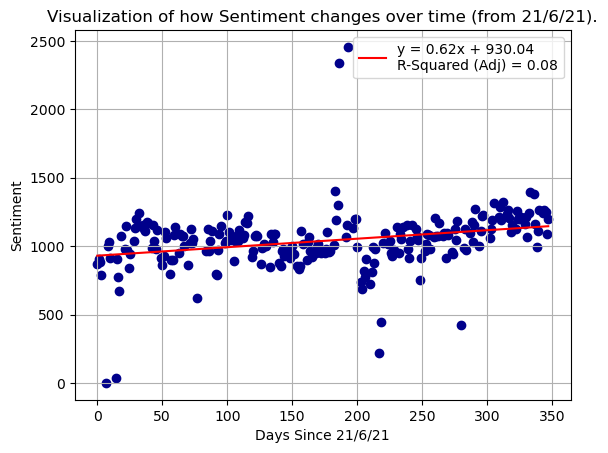

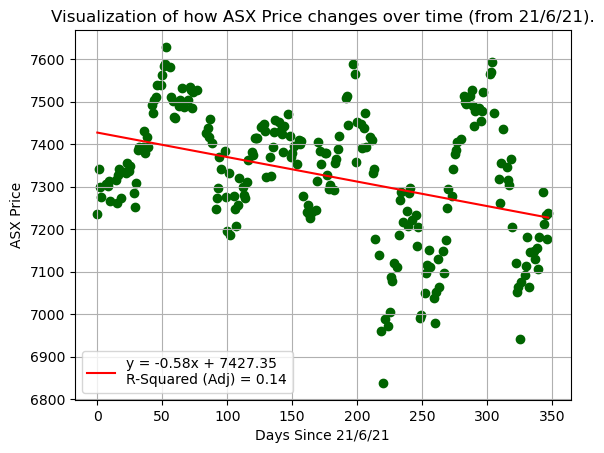

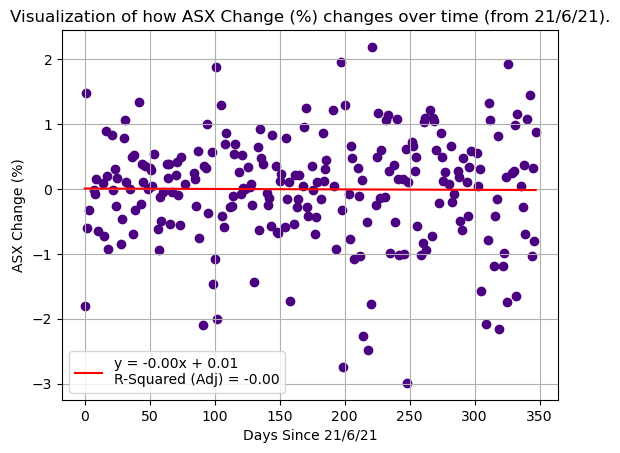

In [10]:
# Analyse change over time.
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

x = np.array(df["Date Index"])
x_label = "Days Since 21/6/21"
field_names = ["Sentiment",  "ASX Price", "ASX Change (%)"]
colors = ["darkblue", "darkgreen", "indigo"]
for field_name, color in zip(field_names, colors):

    # Create regression.
    y = np.array(df[field_name])
    x0 = sm.add_constant(x)
    model = sm.OLS(y, x0).fit()
    y_pred = model.predict(x0)

    # Regression Description String.
    regression_string = ''
    regression_string += f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\n'
    regression_string += f'R-Squared (Adj) = {model.rsquared_adj:.2f}'

    # Plot Datapoints and Regression.
    plt.scatter(x, y, color=color)
    plt.plot(x, y_pred, color='red', label=regression_string)
    plt.title("Visualization of how " + field_name + " changes over time (from 21/6/21).")
    plt.xlabel(x_label)
    plt.ylabel(field_name)
    plt.legend()
    plt.grid(True)
    plt.show()

From above, we see that there appears to be some patterns of fluctuation over time. The time-based regressions seem too simple to pick up anything, which is evident in the low R-Sqaured values. To properly compare Senitments vs. markets, we will conduct regressions of one against the other without date/time as a factor. The aim is to simply see if Price ($) or Price Change (\%) can predict Twitter Sentiments.

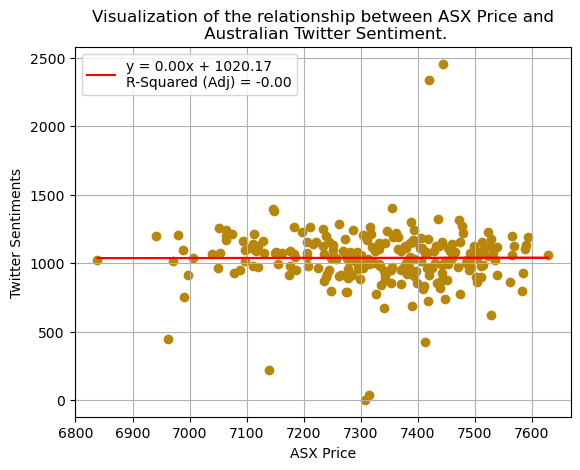

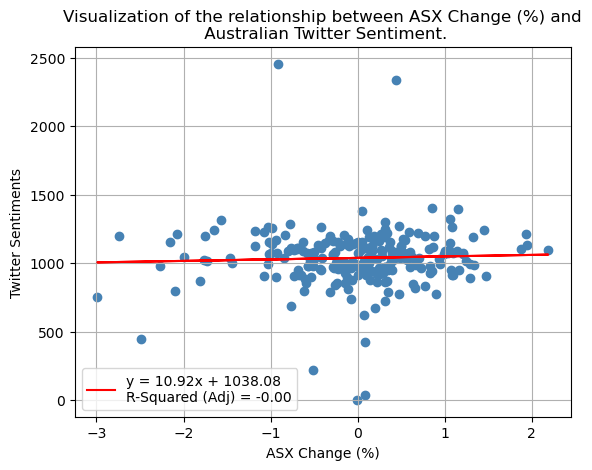

In [11]:
# Directly Sentiment vs ASX.
y = np.array(df["Sentiment"])
y_label = "Twitter Sentiments"

field_names = ["ASX Price", "ASX Change (%)"]
colors = ["darkgoldenrod", "steelblue"]
for field_name, color in zip(field_names, colors):

    # Create regression.
    x = np.array(df[field_name])
    x0 = sm.add_constant(x)
    model = sm.OLS(y, x0).fit()
    y_pred = model.predict(x0)

    # Regression Description String.
    regression_string = ''
    regression_string += f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\n'
    regression_string += f'R-Squared (Adj) = {model.rsquared_adj:.2f}'

    # Plot Datapoints and Regression.
    plt.scatter(x, y, color=color)
    plt.plot(x, y_pred, color='red', label=regression_string)
    plt.title("Visualization of the relationship between " + field_name + " and\n Australian Twitter Sentiment.")
    plt.xlabel(field_name)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()

As shown be the regressions. The R-Squared (adjusted) in both Figures is 0. Moreover even the regression parameter in the Price Change figure is 0. This suggests that there is no meaningful correlation between the two variables. This conclusion is also reinforced by obersving the shapes of the graphs. There seem to be lots of varying Sentiment values alligned with similar Prices and alligned with similar Price Changes.

# Part 2: Twitter Sentiments vs. Unemployment Levels

Next we will observe the aggregate Twitter Sentiments, and unemployment levels across Australian States to attempt to identify if they are correlated.

In [12]:
import requests
import pandas as pd

# Load data from ElasticSearch.
URL = 'http://127.0.0.1:9090/tweets/state'
res = requests.get(URL)
rjson = res.json()

# Iterate over and preprocess Twitter data.
twitter = {}
for hit in rjson['result']['State']["buckets"]:
    state = hit["key"]
    sentiment = hit["Sentiment"]["value"]
    if state not in twitter:
        twitter[state] = 0
    twitter[state] += sentiment

# Store Twitter data in Pandas dataframe.
df_twitter = pd.DataFrame(sorted(twitter.items()), columns=("State", "Sentiment"))
df_twitter.head(10)

,State,Sentiment
0,Australian Capital Territory,1901.743992
1,New South Wales,21176.362950
2,Northern Territory,643.365298
3,Queensland,10999.549968
4,South Australia,4379.314043
5,Tasmania,1060.787892
6,Victoria,21363.919559
7,Western Australia,5352.263237


Now we we load in the by-state unemployment data from the ElasticSearch

In [13]:
# Load data from ElasticSearch.
URL = 'http://127.0.0.1:9090/unemployment/mid'
res = requests.get(URL)
rjson = res.json()
print(rjson)

# Iterate over and preprocess unemployment data.
unemployment_sep21 = {}
unemployment_jun21 = {}
for hit in rjson['result']['State']['buckets']:
    state = hit["key"]
    sep21 = hit["sep_21"]['value']
    jun21 = hit["jun_21"]['value']

    if state not in unemployment_jun21:
        unemployment_jun21[state] = 0
    if state not in unemployment_sep21:
        unemployment_sep21[state] = 0
    unemployment_jun21[state] += jun21
    unemployment_sep21[state] += sep21

# Store unemployment data in Pandas dataframe.
df_sep21 = pd.DataFrame(sorted(unemployment_sep21.items()), columns=("State", "sep_21"))
df_jun21 = pd.DataFrame(sorted(unemployment_jun21.items()), columns=("State", "jun_21"))
df_unemployment = pd.merge(df_sep21, df_jun21, on='State')
df_unemployment.head(10)

{'result': {'State': {'buckets': [{'doc_count': 137, 'jun_21': {'value': 88870.0}, 'key': 'Western Australia', 'sep_21': {'value': 79146.0}}, {'doc_count': 129, 'jun_21': {'value': 262199.0}, 'key': 'New South Wales', 'sep_21': {'value': 236421.0}}, {'doc_count': 80, 'jun_21': {'value': 220421.0}, 'key': 'Victoria', 'sep_21': {'value': 200465.0}}, {'doc_count': 77, 'jun_21': {'value': 186438.0}, 'key': 'Queensland', 'sep_21': {'value': 169675.0}}, {'doc_count': 71, 'jun_21': {'value': 60114.0}, 'key': 'South Australia', 'sep_21': {'value': 54338.0}}, {'doc_count': 29, 'jun_21': {'value': 17456.0}, 'key': 'Tasmania', 'sep_21': {'value': 16328.0}}, {'doc_count': 18, 'jun_21': {'value': 7204.0}, 'key': 'Northern Territory', 'sep_21': {'value': 6693.0}}, {'doc_count': 1, 'jun_21': {'value': 9891.0}, 'key': 'Australian Capital Territory', 'sep_21': {'value': 9674.0}}], 'doc_count_error_upper_bound': 0, 'sum_other_doc_count': 0}}}


,State,sep_21,jun_21
0,Australian Capital Territory,9674.0,9891.0
1,New South Wales,236421.0,262199.0
2,Northern Territory,6693.0,7204.0
3,Queensland,169675.0,186438.0
4,South Australia,54338.0,60114.0
5,Tasmania,16328.0,17456.0
6,Victoria,200465.0,220421.0
7,Western Australia,79146.0,88870.0


Merge datasets by date to facilitate by-State comparisons.

In [14]:
# Merge two datasets.
df = pd.merge(df_twitter, df_unemployment, on='State')
df = df.dropna()
df.head(10)
df["Unemp Avg"] = (df['sep_21'] + df['jun_21']) / 2

# Add renamed and processed columns.
STATE_NAMES_TO_CODES = {"New South Wales": "NSW", "Victoria": "VIC", "Queensland": "QLD", "South Australia": "SA",
                        "Northern Territory": "NT", "Western Australia": "WA", "Tasmania": "TAS",
                        "Australian Capital Territory": "ACT"}
df["State"] = df["State"].apply(STATE_NAMES_TO_CODES.get)
df = df.sort_values(by="Unemp Avg", ascending=False)
df["June 2021"] = df['jun_21']
df["September 2021"] = df['sep_21']
df["Twitter Sentiment"] = df["Sentiment"]
df.head(10)

,State,Sentiment,sep_21,jun_21,Unemp Avg,June 2021,September 2021,Twitter Sentiment
1,NSW,21176.362950,236421.0,262199.0,249310.0,262199.0,236421.0,21176.362950
6,VIC,21363.919559,200465.0,220421.0,210443.0,220421.0,200465.0,21363.919559
3,QLD,10999.549968,169675.0,186438.0,178056.5,186438.0,169675.0,10999.549968
7,WA,5352.263237,79146.0,88870.0,84008.0,88870.0,79146.0,5352.263237
4,SA,4379.314043,54338.0,60114.0,57226.0,60114.0,54338.0,4379.314043
5,TAS,1060.787892,16328.0,17456.0,16892.0,17456.0,16328.0,1060.787892
0,ACT,1901.743992,9674.0,9891.0,9782.5,9891.0,9674.0,1901.743992
2,NT,643.365298,6693.0,7204.0,6948.5,7204.0,6693.0,643.365298


Create Barplots of Twitter Sentiment and Unemployment Data against States. Observe the shapes to try and identify and relationships.

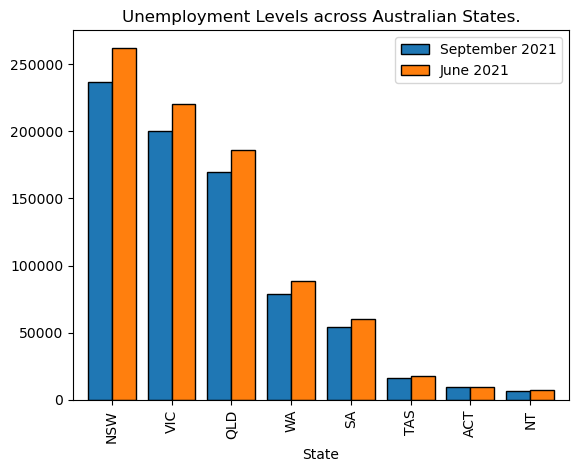

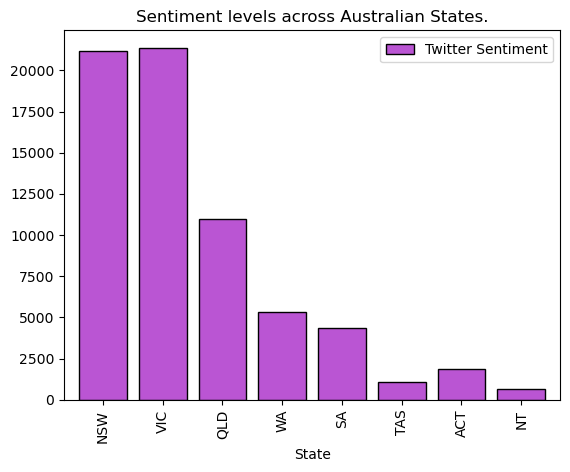

In [15]:
# Analyse General Unemployment levels.
import matplotlib.pyplot as plt

# State vs Unemployment
df[['State', "September 2021", "June 2021"]].plot(x='State', kind='bar', stacked=False, width=0.8, edgecolor='black',
                                                  title='Unemployment Levels across Australian States.')
plt.show()

# State vs Sentiment
df[['State', 'Twitter Sentiment']].plot(x='State', kind='bar', stacked=False, width=0.8, edgecolor='black',
                                        color='mediumorchid', title='Sentiment levels across Australian States.')
plt.show()

The two plots seem to be similiar in shape, however this appears to match with each States population, not each other. Larger states will have more people, thus usually more unemployment. It will also have more users tweeting, and since Sentiments are on average positive, this will result in higher Senitiments. We will adjust the data by state populations to get a more accuarate picture.

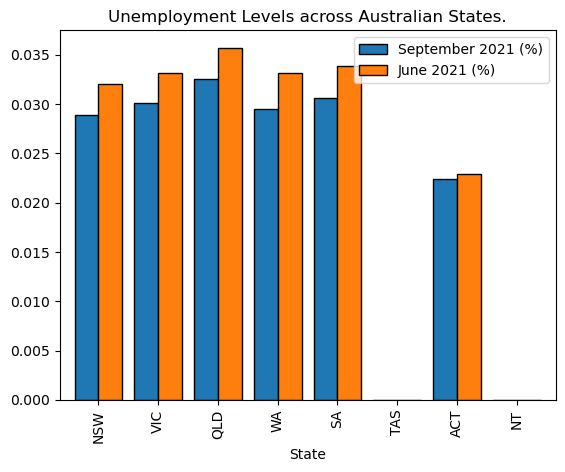

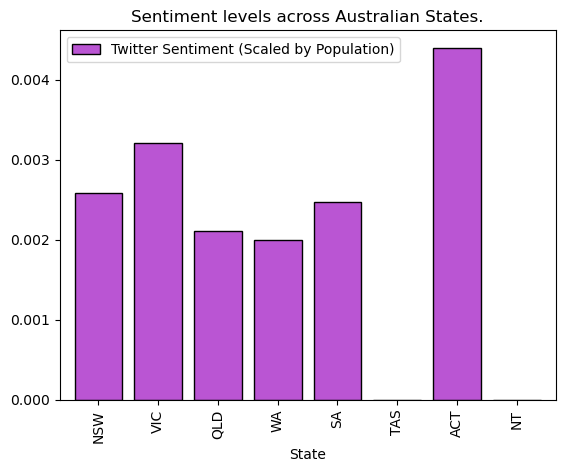

In [16]:
# Scale data by state populations and redo analysis.
POPULATIONS = {'NSW': 8189266, 'VIC': 6649159, 'QLD': 5221170, 'SA': 1773243, 'WA': 2681633, 'TAS': 541479943,
               'NT': 246338103, 'ACT': 432266}
df["Population"] = df["State"].apply(POPULATIONS.get)
df["June 2021 (%)"] = df["June 2021"] / df["Population"]
df["September 2021 (%)"] = df["September 2021"] / df["Population"]
df["Twitter Sentiment (Scaled by Population)"] = df["Sentiment"] / df["Population"]

# State vs Unemployment
df[['State', "September 2021 (%)", "June 2021 (%)"]].plot(x='State', kind='bar', stacked=False, width=0.8, edgecolor='black',
                                                          title='Unemployment Levels across Australian States.')
plt.show()

# State vs Sentiment
df[['State', 'Twitter Sentiment (Scaled by Population)']].plot(x='State', kind='bar', stacked=False, width=0.8, edgecolor='black',
                                                                color='mediumorchid', title='Sentiment levels across Australian States.')
plt.show()

Here, the figures seem to reveal an inverse relationship between Sentiments and unemployment, States with higher Sentiments compared to others seem to have low unemployment compared to others and vice versa. Noteably, NA and TAS, who had low reporting for both datasets, and so they were overscaled down.

# Part 3: ASX 200 vs. Unemployment Levels

Now we will compare total Australian unemployment levels against the average stock prices across quarters. We will start by loading in and processing the ASX 200 dataset.

In [17]:
import requests
import pandas as pd
import numpy as np

# Load data from ElasticSearch.
URL = 'http://127.0.0.1:9090/asx/quarterly'
res = requests.get(URL)
rjson = res.json()

# Iterate over and preprocess ASX data.
asx_quarterly = []
for bucket in rjson['result']['quarters']["buckets"]:
    quarter_start_date = pd.to_datetime(bucket["key_as_string"].split('T')[0])
    quarter = "Q" + str(int(np.ceil(quarter_start_date.month / 3))) + "-" + str(quarter_start_date.year)
    price = float(str(bucket["Price_Average"]["value"]).replace(",", " "))
    asx_quarterly.append((quarter, price))

# Store ASX data in Pandas dataframe.
asx_quarterly.sort()
df_asx_quarterly = pd.DataFrame(asx_quarterly, columns=["Quarter", "ASX Price"])
df_asx_quarterly.head(10)

,Quarter,ASX Price
0,Q1-2012,4242.063515
1,Q1-2013,4932.455751
2,Q1-2014,5324.006434
3,Q1-2015,5722.740337
4,Q1-2016,4998.783611
5,Q1-2017,5737.693677
6,Q1-2018,5972.293536
7,Q1-2019,6017.195171
8,Q1-2020,6430.234956
9,Q1-2021,6766.835504


Now we load in and process the quarterly unemployment dataset.

In [18]:
# Load data from ElasticSearch.
URL = 'http://127.0.0.1:9090/unemployment/quarterly'
res = requests.get(URL)
rjson = res.json()

# Define Quarter fields.
QUARTERS = (["Q4-2010"] + ["Q" + str(i) + "-" + str(y) for y in range(2011, 2020+1) for i in range(1, 4+1)] +
            ["Q1-2021", "Q2-2021", "Q3-2021"])

# Iterate over and preprocess unemployment data.
unemployment = []
for Q in QUARTERS:
    unemployment.append((Q, rjson['result'][Q]['value']))

# Store unemployment data in Pandas dataframe.
unemployment.sort()
df_unemployment_quarterly = pd.DataFrame(unemployment, columns=["Quarter", "Unemployment"])
df_unemployment_quarterly.head(10)

,Quarter,Unemployment
0,Q1-2011,593712.0
1,Q1-2012,604622.0
2,Q1-2013,635944.0
3,Q1-2014,701489.0
4,Q1-2015,752015.0
5,Q1-2016,743878.0
6,Q1-2017,723526.0
7,Q1-2018,718326.0
8,Q1-2019,684516.0
9,Q1-2020,709467.0


Merge datasets by quarters and add ordinality to the dataset.

In [19]:
# Implement a hash for ordering quarters.
REFERENCE_QUARTER = "Q4-2010"
def quarter_index(qaurter, reference_quarter="Q4-2010"):
    q_s, year_s = qaurter.split('-')
    q_s = q_s[1:]

    ref_q_s, ref_year_s = reference_quarter.split('-')
    ref_q_s = ref_q_s[1:]

    return (int(year_s) - int(ref_year_s)) * 4 + (int(q_s) - int(ref_q_s))


df = pd.merge(df_asx_quarterly, df_unemployment_quarterly, on='Quarter')
df = df.dropna()
df["Quarter Index"] = df["Quarter"].apply(quarter_index)
df = df.sort_values(by="Quarter Index")

df.head(10)

,Quarter,ASX Price,Unemployment,Quarter Index
0,Q1-2012,4242.063515,604622.0,5
10,Q2-2012,4198.042605,611074.0,6
20,Q3-2012,4273.696931,615746.0,7
30,Q4-2012,4499.762482,622455.0,8
1,Q1-2013,4932.455751,635944.0,9
11,Q2-2013,4973.269358,653776.0,10
21,Q3-2013,5087.151545,669055.0,11
31,Q4-2013,5288.485939,684110.0,12
2,Q1-2014,5324.006434,701489.0,13
12,Q2-2014,5454.254082,711257.0,14


Create regressions plots of Unemployment vs. time, Price ($) vs. time, and Price Change (\%) vs. time, in order to identify the individual field's shapes / patterns.

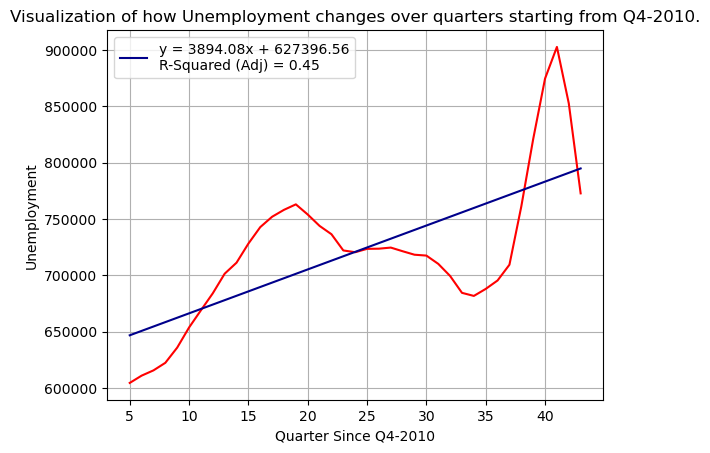

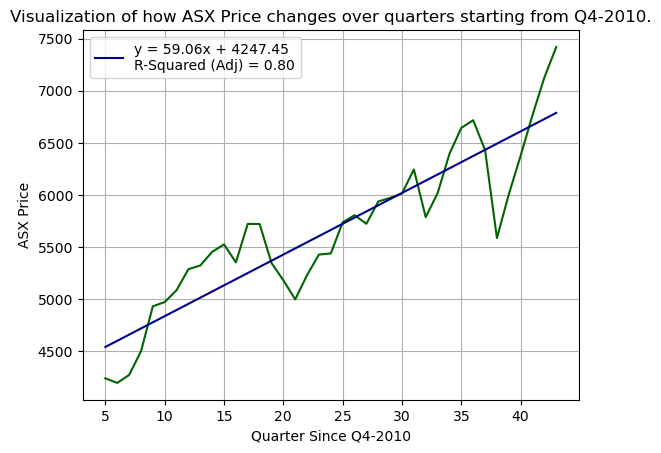

In [20]:
# Analyse change over quarters.
import matplotlib.pyplot as plt
import statsmodels.api as sm

x = np.array(df["Quarter Index"])
x_label = "Quarter Since " + REFERENCE_QUARTER
field_names = ["Unemployment",  "ASX Price"]
colors = ["red", "darkgreen", "orange"]
for field_name, color in zip(field_names, colors):

    # Create regression.
    y = np.array(df[field_name])
    x0 = sm.add_constant(x)
    model = sm.OLS(y, x0).fit()
    y_pred = model.predict(x0)

    # Regression Description String.
    regression_string = ''
    regression_string += f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\n'
    regression_string += f'R-Squared (Adj) = {model.rsquared_adj:.2f}'

    # Plot Datapoints and Regression.
    plt.plot(x, y, color=color)
    plt.plot(x, y_pred, color='darkblue', label=regression_string)
    plt.title("Visualization of how " + field_name + " changes over quarters starting from " + REFERENCE_QUARTER + '.')
    plt.xlabel(x_label)
    plt.ylabel(field_name)
    plt.legend()
    plt.grid(True)
    plt.show()


Now for direct comparison of markets vs. unemployment, we create regressions of Price ($) or Price Change (\%) vs. Unemployment levels to look for correlation.

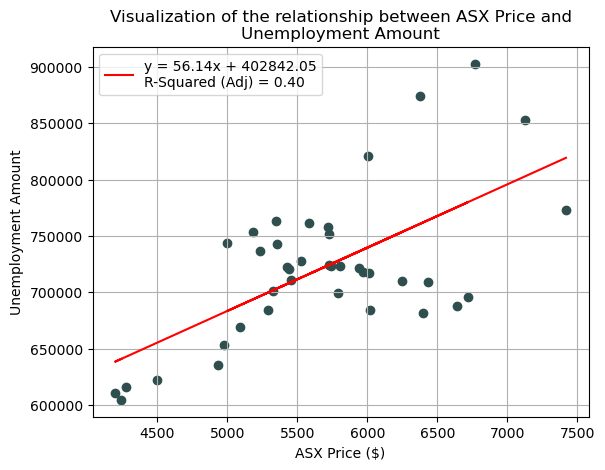

In [21]:
# Directly Unemployment vs ASX.
y = np.array(df["Unemployment"])
y_label = "Unemployment Amount"

# Create regression.
x = np.array(df["ASX Price"])
x0 = sm.add_constant(x)
model = sm.OLS(y, x0).fit()
y_pred = model.predict(x0)

# Regression Description String.
regression_string = ''
regression_string += f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\n'
regression_string += f'R-Squared (Adj) = {model.rsquared_adj:.2f}'

# Plot Datapoints and Regression.
plt.scatter(x, y, color="darkslategrey")
plt.plot(x, y_pred, color='red', label=regression_string)
plt.title("Visualization of the relationship between ASX Price and\n" + y_label)
plt.xlabel("ASX Price ($)")
plt.ylabel(y_label)
plt.legend()
plt.grid(True)
plt.show()

The upwards trend in the unemployment may be purely a concequence of population growth, hence let's scale it by population estimates to get percentage unemployment.

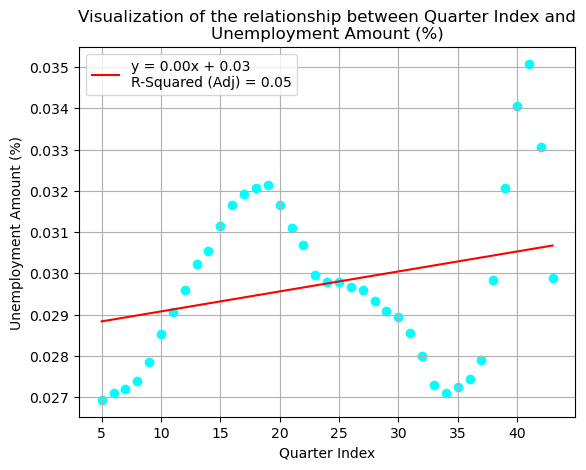

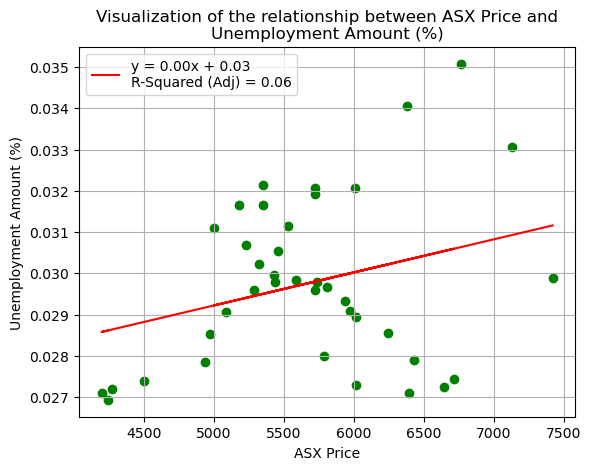

In [22]:
# SOURCE: https://www.macrotrends.net/global-metrics/countries/AUS/australia/population
POPULATION_FIGURES = {2010: 21660892, 2011: 22019168, 2012: 22357034, 2013: 22729269, 2014: 23111782, 2015: 23469579,
                      2016: 23820236, 2017: 24195701, 2018: 24590334, 2019: 24979230, 2020: 25357170, 2021: 25670051,
                      2022: 25921089}
QUARTER_FIGURES = {"Q"+str(i)+"-"+str(year):
                   int((1 - i/4) * POPULATION_FIGURES[year] + (i/4) * POPULATION_FIGURES[year+1])
                   for year in range(2010, 2021+1) for i in range(1, 4 + 1)}

# Re-create figures for scaled data.
df["Unemployment (%)"] = df["Unemployment"] / df["Quarter"].apply(QUARTER_FIGURES.get)
y = np.array(df["Unemployment (%)"])
y_label = "Unemployment Amount (%)"

for field, color in zip(["Quarter Index", "ASX Price"], ["aqua", "green"]):
    # Create regression.
    x = np.array(df[field])
    x0 = sm.add_constant(x)
    model = sm.OLS(y, x0).fit()
    y_pred = model.predict(x0)

    # Regression Description String.
    regression_string = ''
    regression_string += f'y = {model.params[1]:.2f}x + {model.params[0]:.2f}\n'
    regression_string += f'R-Squared (Adj) = {model.rsquared_adj:.2f}'

    # Plot Datapoints and Regression.
    plt.scatter(x, y, color=color)
    plt.plot(x, y_pred, color='red', label=regression_string)
    plt.title("Visualization of the relationship between " + field + " and\n" + y_label)
    plt.xlabel(field)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()